In [43]:
import numpy as np
import matplotlib.pylab as plt
import warnings; warnings.filterwarnings('ignore')
import subprocess
import re

# Introduction to Bayesian Modeling (Part 1a)

## About

**Kamil Dedecius**
- Czech Academy of Sciences, Institute of Information Theory and Automation
- Czech Technical University in Prague, Faculty of Information Technology
- email: dedecius@utia.cas.cz

**Aim and Scope**
- What is the statistical modeling?
- What is special about the Bayesian viewpoint?
- Introduction into MCMC & Stan/pystan
- Some practical models

**Stuff**
- gitlab.com/............

**Recommended reading**
- [John Kruschke: Doing Bayesian Data Analysis: A Tutorial with R, JAGS, and Stan](https://www.amazon.com/Doing-Bayesian-Data-Analysis-Tutorial/dp/0124058884)

## Introduction: What is it good for?

**Bayesian modeling:**
- **mathematical modeling**: we use mathematical representation of phenomena
    - trajectory/velocity/acceleration of a moving object
    - spread of disease
    - DDoS attacks detection
    - image denoising
- branch of **statistical modeling**: there is some randomness in the phenomena
    - the outcomes are uncertain
        - current wind speed/direction
        - IQ of a randomly chosen person
        - number of particles incident to a detector
        - etc.
    - randomness/uncertainty is represented - **modeled** - by statistical distributions (**models**)
        - normal (Gaussian) distribution (IQ)
        - Bernoulli distribution (success/failure)
        - Poisson distribution (counts of particles, people...)
        - beta distribution (probability of an event)
    - the goal is to **estimate** the model parameters
        - fully known model = full (statistical) knowledge of the phenomenon of interest
- unlike the **frequentist statistics**:
    - Bayesian paradigm represents the **knowledge of inferred (estimated) quantities by distributions**
    - may be computationally extremely demanding
    - is often easier to interpret (e.g., the [confidence regions](https://en.wikipedia.org/wiki/Credible_interval#Contrasts_with_confidence_interval))

## Statistical representation of knowledge

**Task: describe probability that our server replies to *ping* within 10ms.**

**First approach:** just decide a number :)

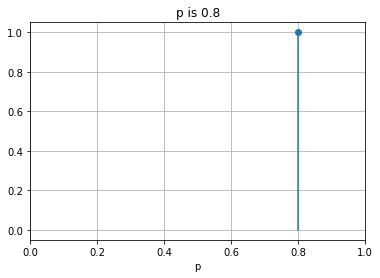

In [74]:
p = 0.8
plt.figure(1)
plt.stem([p], [1])
plt.title(f'p is {p}')
plt.xlabel('p')
plt.xlim(0, 1)
plt.show()

**More sophisticated approach:** try to quantify our **uncertainty**

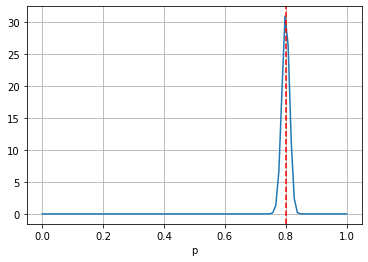

In [75]:
from scipy.stats import beta
a = 800
b = 200
xlocs = np.linspace(0, 1, 100)
plt.figure(1)
plt.plot(xlocs, beta.pdf(xlocs, a, b))
plt.axvline(beta.mean(a,b), ls='dashed' , color='red')
plt.xlabel('p')
#plt.ylabel(r'$\pi(p)$')
#plt.title(f'Probability density function and mean of p ~ beta({a},{b})')
plt.show()

The plot depicts the $p$ je **probability density function of the [beta distribution](https://en.wikipedia.org/wiki/Beta_distribution)**. It's described by the formula

$$
\pi(p|a, b) = \frac{1}{B(a, b)} p^{a-1} (1-p)^{b-1} , \qquad a,b>0,
$$

where

$$
B(a, b) = \frac{\Gamma(a)\Gamma(b)}{\Gamma(a+b)}
$$

is the [beta function](https://en.wikipedia.org/wiki/Beta_function).

### Some interesting properties:
Let us look at the measures of location and dispersion of the beta distribution. If possible, the defining integrals (universally valid for any "probability density") are given. Also recall, that the probability density function integrates to one.

#### **Measures of location:**
- [mean (or expected) value](https://en.wikipedia.org/wiki/Expected_value): $$\mathbb{E}[p] = \mathbb{E}[p|a,b] = \int_{-\infty}^{\infty} p\cdot \pi(p) \mathrm{d}p = \frac{a}{a+b}$$
- [mode (maximum of the pdf)](https://en.wikipedia.org/wiki/Mode_(statistics)): $$\widehat{p} = \frac{a-1}{a+b-2}$$
- [median](https://en.wikipedia.org/wiki/Median): $$\textit{a nasty formula here :D}$$
- see [comparison of the three](https://en.wikipedia.org/wiki/Mode_(statistics)#Comparison_of_mean,_median_and_mode)
- other: quantiles (e.g., quartiles, deciles, percentiles) etc.

#### **Measures of dispection**
- [variance](https://en.wikipedia.org/wiki/Variance): $$\operatorname{var}p = \sigma_p^2 = \int_{-\infty}^{\infty} (p - \mathbb{E}[p])^2 \pi(p)\mathrm{d}p = \frac{ab}{(a+b)^2(a+b+1)}$$
- [standard deviation](https://en.wikipedia.org/wiki/Standard_deviation): $$\sigma_p = \sqrt{\sigma_p^2}$$
- [other](https://en.wikipedia.org/wiki/Statistical_dispersion): range, IQR, median absolute deviation etc.

E[p] = 0.800
median = 0.800
var(p) = 1.598e-04
std(p) = 1.264e-02


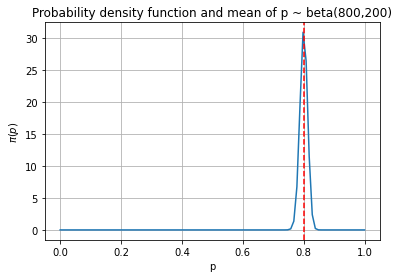

In [42]:
from scipy.stats import beta
a = 800
b = 200
print(f'E[p] = {beta.mean(a, b):.3f}')
print(f'median = {beta.median(a, b):.3f}')
print(f'var(p) = {beta.var(a, b):.3e}')
print(f'std(p) = {beta.std(a, b):.3e}')
xlocs = np.linspace(0, 1, 100)
plt.figure(1)
plt.plot(xlocs, beta.pdf(xlocs, a, b))
plt.axvline(beta.mean(a,b), ls='dashed' , color='red')
plt.xlabel('p')
plt.ylabel(r'$\pi(p)$')
plt.title(f'Probability density function and mean of p ~ beta({a},{b})')
plt.show()

#### Remark
Sometimes, some measures do not exist...
![dists](dists.jpg)

## Data model

Now, we know that **knowledge about some variable of interest** may be represented by a **statistical distribution**. But what's the connection with the data model?

### Example 1: ping & probability of timely response

Let us focus on pinging a server and estimating the probability $p\in[0,1]$ that the pong arrives within $T$ miliseconds. Denote

$$
X =
\begin{cases}
1 &\text{if pong comes within T miliseconds,} \\
0 &\text{otherwise.}
\end{cases}
$$

Similarly, we could use $X=1$ for many binary events such as *success* or *coin head* or *switched on* or *event detected* etc., and $X=0$ for the other cases.

If we are interested in probability of $X=1$, i.e. 

$$
p=\mathrm{Probability}(X=1),
$$

we have

$$
X =
\begin{cases}
1 &\text{with probability $p$,} \\
0 &\text{with probability $1-p$.}
\end{cases}
$$

This may be combined in the following way:

$$
f(x|p) = p^{x} (1-p)^{1-x}.
$$

This is the probability density function (or probability mass function for the discrete nature of $X$) of the [**Bernoulli distribution**](https://en.wikipedia.org/wiki/Bernoulli_distribution)! Try to set $x=0$ and $x=1$ to check that it is consistent with the above definition ;-)


**GREAT! This is our first statistical model! :)**

Just for completeness:
$$
\mathbb{E}[X] = p, \qquad \operatorname{var}X = p(1-p).
$$

**Let's try a ping (perhaps doesn't work on Windows):**

In [66]:
hostname = 'www.google.com'
T = 10

def ping(hostname):
    ping = subprocess.Popen(["hping3", '-S', '-p', '80', '-c', '1', '-i', '15', hostname],
                            stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    res = str(ping.stderr.readlines()[-1])
    out = re.split(r'/', res)
    return float(out[3])

pong_time = ping(hostname)
print(f'X = {1 if pong_time < T else 0}')
print(f'(pong time: {pong_time})')

X = 1
(pong time: 8.115)


**TASK:** For simplicity assume, that $p$ is "relatively" constant (this can be reasonable if we measure responsiveness of a local network component). How do we estimate it?

## Example 2: a bunch of pings

One ping is for loosers! We want $n\geq 1$ pings!

Each ping is a Bernoulli trial, and $n$ pings are $n$ trials. We denote by $k$ the number of "successfull" pings and obtain a pdf

$$
f(Y=k|p) = \binom{n}{k}p^k (1-p)^{1-k}.
$$

The mean and the variance read

$$
\mathbb{E}[Y] = np, \qquad \operatorname{var}Y = np(1-p).
$$

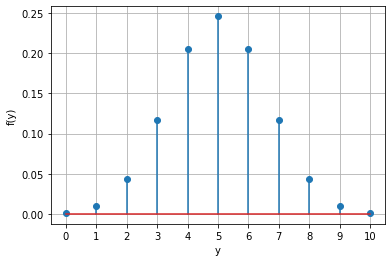

In [67]:
from scipy.stats import binom
n = 10                               # Number of trials
p = .5                               # Probability of success
ks = np.arange(0, n+1)
probs = binom.pmf(n=n, p=p, k=ks)
plt.stem(ks, probs)
plt.xticks(ks)
plt.xlabel('y')
plt.ylabel('f(y)')
plt.show()

### Examples: Final remarks

There are several types of [estimation methods](https://en.wikipedia.org/wiki/Estimation_theory#Estimators). The most basic ones are:
- [Method of Moments (MoM)](https://en.wikipedia.org/wiki/Method_of_moments_(statistics))
    - Matches the sample moments to the theoretical ones
- [Maximum Likelihood Estimators (MLE)](Maximum_likelihood_estimation)
    - Given a statistical model, it seeks the value of the unknown parameter so that the observed data are most probable.
- [Bayesian Estimators](https://en.wikipedia.org/wiki/Bayes_estimator)
    - See below.

# Bayesian approach to inference

- **The model is uncertain.**
- **Bayesian approach fixes data, not parameters.**
- **The parameters are modeled as random variables, but they are fixed variates. The randomness is connected with our knowledge about them.**
- **Knowledge about parameters is described by prior/posterior distribution. To prevent confusion with the parameters of interest, its parameters are called 'hyperparameters'**
- **Prior knowledge = what we know before incorporating new observations (data).**
- **Posterior knowledge = prior knowledge + new data.**

Let us assume a random variable $X$ with a realization $x$ and a parameter $\theta$. The **Bayes' theorem** says that

$$
\pi(\theta|X=x) = \pi(\theta|x) = \frac{f(x|\theta) \pi(\theta)}{f(x)}, \qquad f(x) > 0,
$$

where
- $\pi(\theta|x)$ is the **posterior** distribution (pdf, knowledge) of $X$,
- $\pi(\theta)$ is the **prior** distribution,
- $f(x|\theta)$ is the **data model** (see examples above),
- $f(x)$ is the **evidence**, aka **normalizing factor** (*Q: why do we need it?*)

Since the denominator is independent of $\theta$ and "easily" follows from

$$f(x) = \int f(x|\theta) p(\theta) d\theta$$

we often write the theorem in a shorter form with proportionality:

$$
\pi(\theta|x) \propto f(x|\theta) \pi(\theta).
$$

### Update with multiple data

The posterior distribution summarizes the prior knowledge + knowledge brought by data. If we obtain new data, it may be immediately reused as the prior for a new Bayesian update:

$$
\begin{aligned}
\pi(\theta|x_1) &\propto f(x_1|\theta)\, \pi(\theta),\\[3mm]
\pi(\theta|x_1, x_2) &\propto f(x_2|\theta)\, \pi(\theta|x_1) \\[2mm]
&\propto f(x_2|\theta)\, f(x_1|\theta)\,\pi(\theta) \\[2mm]
&\propto \pi(\theta)\cdot \prod f(x_i|\theta).
\end{aligned}
$$

If you are familiar with the frequency statistics, do you recognize the likelihood? ;)

### Example: Bernoulli model with unknown probability $p$

Let us recall the Bernoulli model for a ping with $X=0$ being failure and $X=1$ success, respectively. The pdf reads

$$
f(x|p) = p^{x} (1-p)^{1-x},
$$

where $p$ is the probability of success. For instance, if 70% of pings end with success, $p=0.7$. However, we usually don't know $p$ and want to estimate it.

#### Prior distribution

Since $p$ is between 0 and 1, we may want a distribution limited to this interval. A convenient distribution is the (familiar) beta distribution parameterized by two parameters $a,b>0$ with a pdf

$$
\pi(p|a, b) = \frac{1}{B(a, b)} p^{a-1} (1-p)^{b-1},
$$

where

$$
B(a, b) = \frac{\Gamma(a)\Gamma(b)}{\Gamma(a+b)}
$$

is the [beta function](https://en.wikipedia.org/wiki/Beta_function). Fortunately, we are not interested in this beautiful function :)

What we need is the mean and the variance. The former can be used as the **point estimate of $p$**, the latter as the **measure of uncertainty**. They are

$$
\mathbb{E}[p] = \mathbb{E}[p|a,b] = \frac{a}{a+b}, \qquad
\operatorname{var}p = \frac{ab}{(a+b)^2(a+b+1)}.
$$

#### Posterior distribution

From the Bayes' formula we see that

$$
\text{posterior} \propto \text{model} \times \text{prior},
$$

formally and with our distributions,

$$
\begin{aligned}
\pi(p|x) &\propto f(x|p) \pi(p) \\[2mm]
&\propto p^x (1-p)^{1-x} \cdot \frac{1}{B(a, b)} p^{a-1} (1-p)^{b-1} \\[2mm]
&\propto p^{a+x-1} (1-p)^{b+(1-x) - 1} \\[2mm]
&\propto p^{a_1 - 1} (1-p)^{b_1 - 1},
\end{aligned}
$$

where

$$
a_1 = a + x \qquad\text{and}\qquad b_1 = b+(1-x).
$$

Recall, that $x=1$ means success and $x=0$ stands for failure. That is, the hyperparameter $a$ is a counter of successes and $b$ is a counter of failures! And the **posterior distribution is (proportional to) the beta distribution**, i.e.

$$
\text{beta prior} \times \text{Bernoulli model} \to \text{beta posterior}.
$$

How smart! We end with a nice standard distribution, know the formulae for its mean and variance and are ready for a subsequent update by new data. Alternatively, we may directly add the number of successes to the hyperparameter $a$ and the number of failures to $b$, as it is perfectly equivalent (see above).

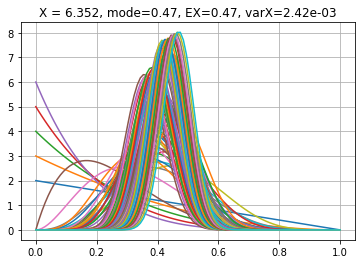

In [73]:
from scipy.stats import beta
import time
a = 1
b = 1

xlocs = np.linspace(0, 1, 100)

fig = plt.figure(1)
ax = fig.add_subplot(111)
#plt.ion()
fig.show()
fig.canvas.draw()

for i in range(100):
    X = ping(hostname)
    if X <= 7:
        a += 1
    else:
        b += 1
    #fig.clf() # comment out
    plt.plot(xlocs, beta.pdf(xlocs, a, b))
    plt.title(f'X = {X}, mode={beta.median(a,b):.2f}, EX={beta.mean(a,b):.2f}, varX={beta.var(a,b):.2e}')
    fig.canvas.draw()
    time.sleep(.1)

### Remarks

The preservation of the prior-posterior distribution form (here beta - beta) is very useful in online tasks. This case, called [**conjugacy**](https://en.wikipedia.org/wiki/Conjugate_prior), is unfortunately rather rare. If we used other distributions for the prior, the posterior will not be standard and we could not find its properties easily (say, on wikipedia).

#### How to choose the prior distribution?

The answer is very complicated, but some guideliness:
- the support of the prior should cover the true parameter value.
- the lower knowledge, the flatter the prior.
- for online tasks, search for conjugate prior.